# Perceptron, Adaline, and Optimization

Tutor link: https://nthu-datalab.github.io/ml/labs/04-1_Perceptron_Adaline/04-1_Perceptron_Adaline.html


In [203]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


## Load and split dataset


In [204]:
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/" "machine-learning-databases/iris/iris.data",
    header=None,
)
df.columns = [
    "Sepal length",
    "Sepal width",
    "Petal length",
    "Petal width",
    "Class label",
]
display(df.head())

X = df[["Petal length", "Petal width"]].values
y = pd.factorize(df["Class label"])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print("# Training data points: %d" % X_train.shape[0])
print("# Testing data points: %d" % X_test.shape[0])
print("Class labels: %s" % np.unique(y))


,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Training data points: 80
# Testing data points: 20
Class labels: [-1  1]


## Adaline with SGD


In [205]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.

    """

    def __init__(self, eta=0.01, n_iter=50, M=1, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.batch_size = M
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            np.random.seed(random_state)

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        self.cost_ = []
        for _ in range(self.n_iter):
            X_batched, y_batched = self.batch_split(X, y)
            cost = []
            for x_batch, y_batch in zip(X_batched, y_batched):
                cost += self.partial_fit(x_batch, y_batch)
            avg_cost = sum(cost) / len(y_batched)
            self.cost_.append(avg_cost)
        return self

    def batch_split(self, X, y):
        if self.shuffle:
            X, y = self._shuffle(X, y)

        split_indices = [i for i in range(0, len(X), self.batch_size)]
        split_indices.append(X.shape[0])

        X_batched = [
            X_train_std[split_indices[i] : split_indices[i + 1]]
            for i in range(len(split_indices) - 1)
        ]
        y_batched = [
            y_train[split_indices[i] : split_indices[i + 1]]
            for i in range(len(split_indices) - 1)
        ]

        return X_batched, y_batched

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True

    def _update_weights(self, xi, yi):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)

        # Cost function
        error = yi - output
        cost = 0.5 * error**2

        # Update rule
        self.w_[1:] += self.eta * xi.T.dot(error)
        self.w_[0] += self.eta * error.item()

        return cost

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        cost = []
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, yi in zip(X, y):
                cost.append(self._update_weights(xi, yi))
        else:
            cost.append(self._update_weights(X, y))
        return cost


In [206]:
costs = []
for m in range(1, 4):
    adas = AdalineSGD(n_iter=20, eta=0.01, M=m, random_state=1)
    y_pred = adas.fit(X_train_std, y_train).predict(X_test_std)
    costs.append(adas.cost_)

    print(f"========== M = {m} ==========")
    print("Misclassified samples: %d" % (y_test != y_pred).sum())
    print("Accuracy: %.2f\n" % accuracy_score(y_test, y_pred))


========== M = 1 ==========
Misclassified samples: 3
Accuracy: 0.85

========== M = 2 ==========
Misclassified samples: 3
Accuracy: 0.85

========== M = 3 ==========
Misclassified samples: 3
Accuracy: 0.85



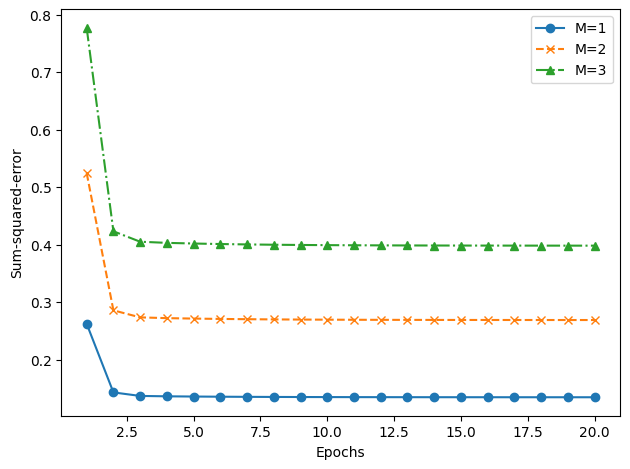

In [208]:
plt.plot(range(1, len(costs[0]) + 1), costs[0], marker="o", label="M=1")
plt.plot(
    range(1, len(costs[0]) + 1),
    costs[1],
    marker="x",
    linestyle="--",
    label="M=2",
)
plt.plot(
    range(1, len(costs[0]) + 1),
    costs[2],
    marker="^",
    linestyle="-.",
    label="M=3",
)
plt.xlabel("Epochs")
plt.ylabel("Sum-squared-error")
plt.legend(loc="upper right")

if not os.path.exists("./output"):
    os.makedirs("./output")

plt.tight_layout()
plt.savefig("./output/fig-adaline-sgd-cost.png", dpi=300)
plt.show()
